In [1]:
from ast import Lambda
import tensorflow as tf
import json

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
dataset_path = r"D:\ObjectDetection\datasets\COCO-2017\val2017"
anno_path = r"D:\ObjectDetection\datasets\COCO-2017\annotations_trainval2017\annotations\instances_val2017.json"

In [3]:
with open(anno_path) as file:
    anno_file = json.load(file)

In [26]:
anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

In [28]:
anchor_idxs = anchor_masks[0]
anchor_idxs

array([6, 7, 8])

In [29]:
anchor_idxs = tf.cast(anchor_idxs, tf.int32)
anchor_idxs

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([6, 7, 8])>

In [54]:
anchor_eq = tf.equal(anchor_idxs, 8)
anchor_eq

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([False, False,  True])>

In [55]:
tf.reduce_any(anchor_eq)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [56]:
anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
anchor_idx

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[2]])>

In [57]:
y = [[173.998505, 0.702, 359.794495, 398.235504, 1, 51],
 [54.8015, 202.624496, 203.443481, 410.156494, 1, 51],
 [201.025497, 162.24, 360.327515, 367.796, 1, 56]]

In [58]:
y = tf.cast(y, dtype=tf.float32)
y

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[173.9985 ,   0.702  , 359.7945 , 398.2355 ,   1.     ,  51.     ],
       [ 54.8015 , 202.6245 , 203.44348, 410.1565 ,   1.     ,  51.     ],
       [201.0255 , 162.24   , 360.3275 , 367.796  ,   1.     ,  56.     ]],
      dtype=float32)>

In [59]:
box_xy = (y[0][0:2] + y[0][2:4]) / 2
box_xy

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([266.89648, 199.46875], dtype=float32)>

In [60]:
grid_size = 416 // 32
grid_size

13

In [61]:
grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)
grid_xy

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([3469, 2593])>

In [52]:
grid_xy = tf.cast(box_xy // grid_size, tf.int32)
grid_xy

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([20, 15])>

In [53]:
20*15

300

In [50]:
16*13*13*3*6

48672

In [132]:
x = cv2.imread(os.path.join(dataset_path, "000000000724.jpg"))
x = tf.cast(x, dtype=tf.float32)
y = [an["bbox"] + [an["category_id"]] for an in anno_file["annotations"] if an["image_id"] == 724]
resize_dims = [450, 400]

In [136]:
target_size = tf.constant(resize_dims)
target_size = tf.reverse(target_size, axis=(-1,))    

tf.print(tf.shape(x))
tf.print(target_size)

# finding scaling and shifting
scale = tf.zeros(2, dtype=tf.float32)
shift = tf.zeros(2, dtype=tf.float32)
ar = tf.cast(tf.shape(x)[1]/tf.shape(x)[0], dtype=tf.float32)
max_ = tf.cast(target_size[tf.argmax(target_size)], dtype=tf.float32) 
min_ = tf.cast(target_size[tf.argmin(target_size)], dtype=tf.float32) 
if tf.argmax(tf.shape(x)[:-1]) == tf.argmax(target_size):
    indexes = [[tf.argmax(target_size)], [tf.argmin(target_size)]]
    updates_scale = [max_, max_ / ar]
    updates_shift = [0, (min_ - max_ / ar) / 2]
else:
    indexes = [[tf.argmin(target_size)], [tf.argmax(target_size)]]
    updates_scale = [min_, min_ * ar]
    updates_shift = [0, (max_ - min_ * ar) / 2]
scale = tf.tensor_scatter_nd_update(scale, indexes, updates_scale)
scale = tf.divide(scale, (tf.shape(x)[0], tf.shape(x)[1]))
shift = tf.tensor_scatter_nd_update(shift, indexes, updates_shift)

[500 375 3]
[400 450]


In [139]:
tf.argmin([32, 32])

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [135]:
tf.argmax(tf.shape(x)[:-1]) == tf.argmax(target_size)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [130]:
scale

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8, 0.8], dtype=float32)>

In [ ]:
# resize image
x = tf.image.resize_with_pad(x, target_size[0], target_size[1])
x = tf.divide(x, 255)

# resize bouding box 
# original bouding box shape is [ymin, xmin, width, height]
boxes, classes = tf.split(y, (4, 1), axis=-1)
boxes = tf.multiply(boxes, (scale[1], scale[0], scale[1], scale[0]))
boxes = tf.add(boxes, (shift[1], shift[0], 0, 0))
y = tf.concat([boxes, classes], axis=-1)

paddings = [[0, 50 - tf.shape(y)[0]], [0, 0]]
y = tf.pad(y, paddings)

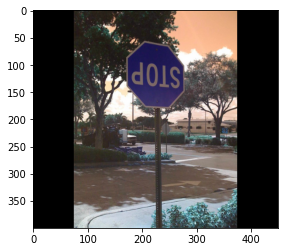

In [120]:
plt.imshow(x)